#**FACE RECOGNITION**

---
BPNN Vektoral 30x30 | Train-Testing

##**Import Libraries**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import math
import random
import string
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


##**Pemrosesan Gambar**

In [4]:
# Path ke dataset di Google Drive
input_path = "/content/drive/My Drive/FaceRec_NN/INVALID_data30x30"

**Flatten Data**

In [5]:
def flatten_image(input_directory):
    # List all folders in the input directory
    folders = [f for f in os.listdir(input_directory) if os.path.isdir(os.path.join(input_directory, f))]
    print(f"Found folders: {folders}")

    # Initialize arrays for inputs and outputs
    X = []
    y = []

    # Create a mapping from folder names to one-hot encoded labels
    label_map = {folder: idx for idx, folder in enumerate(folders)}
    num_classes = len(folders)

    # Process each folder and photo
    for folder in folders:
        folder_path = os.path.join(input_directory, folder)

        # Sort the list of photos to ensure consistent order
        photos = sorted([p for p in os.listdir(folder_path) if p.endswith(('.png', '.jpg', '.jpeg'))])

        for photo in photos:
            photo_path = os.path.join(folder_path, photo)
            image = Image.open(photo_path)

            # Convert the image to a numpy array and flatten it
            image_array = np.array(image).flatten()
            X.append(image_array)

            # Create a one-hot encoded label
            label = np.zeros(num_classes)
            label[label_map[folder]] = 1
            y.append(label)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

**Normalisasi Data**

In [6]:
class NormalizeImage:
    def __init__(self, data):
        self.data = data

    def transform(self):
        #modified so the range of normalized data is [-1, 1]
        return self.data/255

    def inverse_transform(self):
        return self.data*255

##**Split Data (Train-Testing)**

In [11]:
def split_train_test(combined_array):
    np.random.shuffle(combined_array)
    # Calculate the split indices
    num_samples = combined_array.shape[0]
    train_end = int(0.7 * num_samples) # 70% of the data is used for training

    # Split the data into training, testing, and validation sets
    train_data = combined_array[:train_end]
    test_data = combined_array[train_end:]

    return train_data, test_data

def split_input_output(data, num_input_features):
    X_data = data[:, :num_input_features]
    y_data = data[:, num_input_features:]
    return X_data, y_data

In [12]:
X, y = flatten_image(input_path)

scalerinput = NormalizeImage(X)
X_normalized = scalerinput.transform()
combined_array = np.hstack((X_normalized, y))

train_data, test_data = split_train_test(combined_array)
num_input_features = X.shape[1]
X_train, y_train = split_input_output(train_data, num_input_features)
X_test, y_test = split_input_output(test_data, num_input_features)

print(f"Training data  : {X_train.shape}, {y_train.shape}")
print(f"Testing data   : {X_test.shape}, {y_test.shape}")

Found folders: ['Toni', 'Keiko', 'Fadhli', 'Fadlin', 'David', 'Azmira', 'Dimas', 'Hafidz', 'Haidar', 'Hanna', 'Khansa', 'Mikhael', 'Puti', 'Raesa', 'Satwika']
Training data  : (968, 900), (968, 15)
Testing data   : (416, 900), (416, 15)


##**Implementasi Kode**

**Fungsi Aktivasi**

In [14]:
# fungsi sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# fungsi RELu
def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return np.where(x > 0, 1, 0)

# fungsi softmax
def softmax(x):
    exps = np.exp(x - np.max(x))  # Stabilize softmax by subtracting max
    return exps / np.sum(exps)

def d_softmax(x):
    return softmax(x) * (1 - softmax(x))

**Insialisasi**

(1) Parameter

In [25]:
epoch = 10000
lr = 0.05            # learning rate
stoping_tr = 0.01    # batas error

NI = 900             # input neuron (node) 30x30
NH = 64              # hidden neuron (node)
hiddenLayer = 1
NO = 15              # output neuron (node)

(2) Bobot (Weight)

In [26]:
def weightsd(NI, NH, NO, seed=42):
    """
    Inisialisasi bobot dengan menggunakan He Initialization
    """
    rng = np.random.default_rng(seed)  # Inisialisasi RNG dengan seed
    std = math.sqrt(2.0 / NI)          # Standar deviasi untuk He Initialization

    v_weights = rng.normal(0, std, (NI, NH))  # Bobot input-hidden
    vb_weights = rng.normal(0, std, (1, NH))  # Bias hidden
    w_weights = rng.normal(0, std, (NH, NO))  # Bobot hidden-output
    wb_weights = rng.normal(0, std, (1, NO))  # Bias output

    return v_weights, vb_weights, w_weights, wb_weights

In [27]:
v, vb, w, wb = weightsd(NI, NH, NO)

print("Rentang v : ", v.min(), v.max())
print(np.shape(v))
print("Rentang vb: ", vb.min(), vb.max())
print(np.shape(vb))
print("Rentang w : ", w.min(), w.max())
print(np.shape(w))
print("Rentang wb: ", wb.min(), wb.max())
print(np.shape(wb))

Rentang v :  -0.20690484575751364 0.2360433324986031
(900, 64)
Rentang vb:  -0.1313621731783457 0.09961085425917048
(1, 64)
Rentang w :  -0.14565627430298533 0.16919191353529503
(64, 15)
Rentang wb:  -0.12832417556137854 0.06879327793110158
(1, 15)


**BPNN**

(1) Feedforward

In [28]:
def feedForward(x, v, vb, w, wb):
    # sinyal unit hidden
    z_in = np.dot(x, v) + vb   # sinyal input unit hidden
    z = relu(z_in)             # sinyal output unit hidden dengan f.aktivasi

    # sinyal unit output
    y_in = np.dot(z, w) + wb   # sinyal input unit output
    y = softmax(y_in)          # sinyal output unit output dengan f.aktivasi


    # Flatten activation to avoid shape issues
    z_in = z_in.flatten()
    z = z.flatten()
    y_in = y_in.flatten()
    y = y.flatten()

    return z_in, z, y_in, y

(2) Backpropagation of Error

In [29]:
def backPropagation(x, t, z, z_in, y, y_in, v, vb, w, wb, NH, NO, lr):
    delta_y = (t - y) * d_softmax(y_in) # error unit output
    del_w = lr * np.outer(z, delta_y)   # koreksi bobot unit output
    del_wb = lr * delta_y               # koreksi bobot bias unit output

    delta_zin = np.dot(delta_y, w.T)    # error unit hidden
    delta_z = delta_zin * d_relu(z_in)  # aktivasi koreksi error unit hidden
    del_v = lr * np.outer(x, delta_z)   # koreksi bobot unit hidden
    del_vb = lr * delta_z               # koreksi bobot bias unit hidden

    # update bobot dan bias unit output
    w += del_w
    wb += del_wb

    # update bobot dan bias unit hedden
    v += del_v
    vb += del_vb

    return v, vb, w, wb

(3) **Training Model**

In [30]:
for e in range(epoch):
    total_error_cross_entropy = 0

    for i in range(len(X_train)):
        x = X_train[i]
        t = y_train[i]

        z_in, z, y_in, y = feedForward(x, v, vb, w, wb)
        v, vb, w, wb = backPropagation(x, t, z, z_in, y, y_in, v, vb, w, wb, NH, NO, lr)

        cross_entropy = -np.sum(t * np.log(y + 1e-15))
        total_error_cross_entropy += cross_entropy

    # Average error for the epoch
    avg_error = total_error_cross_entropy / len(X_train)

    if e % 100 == 0 or e == epoch - 1:
        print(f"Epoch: {e + 1}/{epoch}, Error: {avg_error: .5f}")

    # Early stopping condition
    if avg_error < stoping_tr or e == epoch - 1:
        print(f"Early stopping triggered at epoch {e + 1} with error {avg_error: .4f}.")
        break

Epoch: 1/10000, Error:  2.64646
Epoch: 101/10000, Error:  0.01198
Epoch: 201/10000, Error:  0.01151
Epoch: 301/10000, Error:  0.01086
Early stopping triggered at epoch 370 with error  0.0100.


##**Evaluasi**

Testing Accuracy: 90.14%


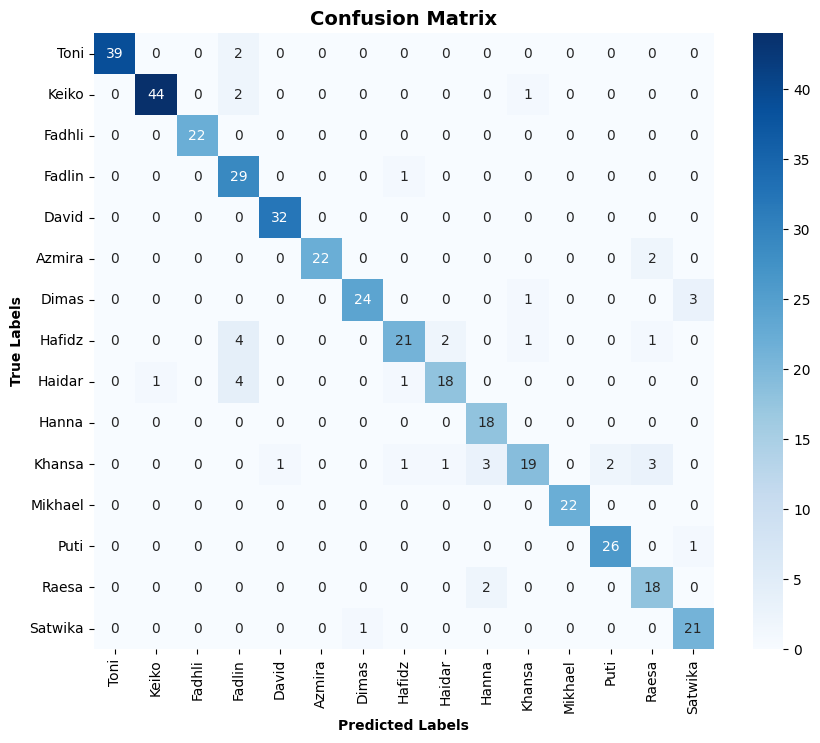

In [31]:
# Evaluasi model
y_preds = []
for x in X_test:
    _, _, _, y = feedForward(x, v, vb, w, wb)
    y_preds.append(np.argmax(y))  # Prediksi kelas berdasarkan output softmax

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_preds)
print(f"Testing Accuracy: {accuracy:.2%}")

# berdasarkan flattend data
class_names = ["Toni", 'Keiko', 'Fadhli', 'Fadlin', 'David',
               'Azmira', 'Dimas', 'Hafidz', 'Haidar', 'Hanna',
               'Khansa', 'Mikhael', 'Puti', 'Raesa', 'Satwika']

cm = confusion_matrix(np.argmax(y_test, axis=1), y_preds)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels", weight = 'bold')
plt.ylabel("True Labels", weight = 'bold')
plt.title("Confusion Matrix", fontsize = 14, weight = 'bold')
plt.show()

#**CONCLUSION**
---
